# Covid-19

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import json

In [15]:
cases_url = ('https://raw.githubusercontent.com/CSSEGISandData/'
            'COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
            'time_series_19-covid-Confirmed.csv')

In [16]:
df = pd.read_csv(cases_url)
per_nation = df.drop(['Lat', 'Long'], axis=1).groupby(['Country/Region']).sum()
per_nation['tot'] = per_nation.sum(axis=1)
per_nation.head(3)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,tot
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1,4,4,5,7,7,7,11,16,74
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,2,10,12,23,33,38,42,160
Algeria,0,0,0,0,0,0,0,0,0,0,...,17,19,20,20,20,24,26,37,48,286


In [37]:
cases = (per_nation.drop(['Lat', 'Long', 'tot'], axis=1, errors='ignore')
         .drop(['Others'], errors='ignore').T)
cases['World'] = cases.sum(axis=1)

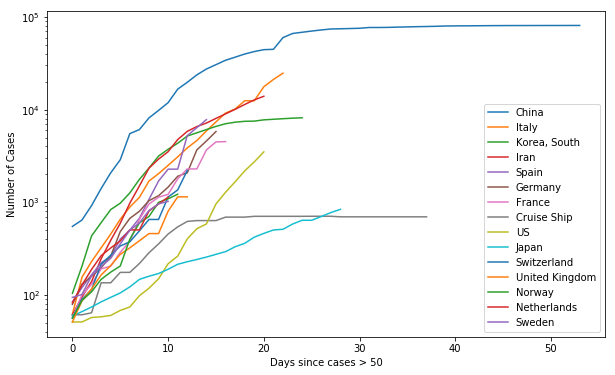

In [18]:
large = (per_nation.loc[per_nation['tot'].nlargest(15).index]
         .drop(['Lat', 'Long', 'tot'],
         axis=1, errors='ignore').drop(['Others'], errors='ignore').T)
plt.figure(figsize=(10, 6))
for land in large.columns:
    cases_large = large[land][large[land] > 50].values
    plt.plot(cases_large, label=land)
plt.legend()
plt.ylabel('Number of Cases')
plt.xlabel('Days since cases > 50')
plt.yscale('log')
plt.savefig('cases_per_land.png')
plt.show()

In [19]:
def model_nation(nation, min_cases=50):
    Y = np.log(cases[nation][cases[nation] > min_cases].values)
    X = sm.add_constant(np.array(range(len(Y))))
    model = sm.OLS(Y, X).fit()
    return model

In [20]:
def plot_nation(nation, dasy_to_model=10, min_cases=50):
    model = model_nation(nation, min_cases)
    real = cases[nation][cases[nation] > min_cases].values
    max_days = real.shape[0] + dasy_to_model
    modelled = (cases[nation][cases[nation] > min_cases]
                .iloc[0]*np.exp(model.params[1]*np.arange(1, max_days)))
    plt.title(nation)
    plt.plot(modelled, label='Model', linewidth=3.0)
    plt.plot(real, label='Real Data', linewidth=3.0)
    plt.xticks(np.arange(modelled.shape[0])[::2])
    plt.xlabel('Days since cases>{}'.format(min_cases))
    plt.ylabel('Number of cases')
    plt.gca().yaxis.grid(True)
    plt.legend()
    plt.savefig('model_vs_reality_{}.png'.format(nation))

In [27]:
def compare_nations(nations, min_cases=50, log=False):
    max_ticks = []
    plt.figure(figsize=(10, 6))
    for nation in nations:
        real = cases[nation][cases[nation] > min_cases].values
        ticks = np.arange(cases[nation][cases[nation] > min_cases].values.shape[0])
        if len(max_ticks) < len(ticks):
            max_ticks = ticks
        plt.title(nation)
        plt.plot(real, label=nation, linewidth=3.0)
    if log:
        plt.yscale('log')
    plt.xticks(max_ticks[::2])
    plt.xlabel('Days since cases>{}'.format(min_cases))
    plt.ylabel('Number of cases')
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.legend()
    plt.savefig('multiple_nations.png')

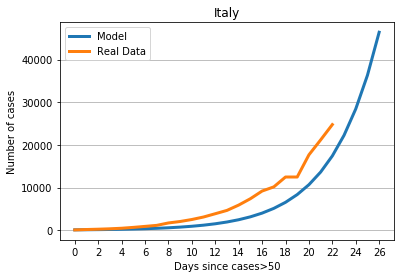

In [22]:
plot_nation('Italy', 5)

In [23]:
df[df['Country/Region'] == 'Italy']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747


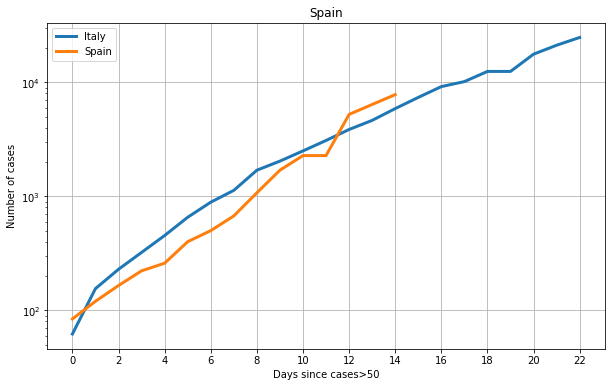

In [28]:
compare_nations(['Italy', 'Spain'], min_cases=50, log=True)

In [25]:
json_url = '/home/matteo/Documents/Programming/covid-19-website/confirmed.json'

In [38]:
cases_to_save = cases[cases.columns[cases.sum()>100]]

In [39]:
with open(json_url, 'w') as j:
    j.write(json.dumps(cases_to_save.to_dict('list')))